## Getting Started

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

In [6]:
from official import nlp
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're us

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

## Data and Modeling

In [ ]:
def data_process(name):
  dataset = pd.read_csv('/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/dataset/train_data.csv')
  if name == 'MultiPlatform':
        data = dataset.sample(frac=1, random_state=42)
        data.reset_index(inplace=True, drop=True)
  else:
    data_pf = dataset[dataset.platform==name]
    data = data_pf.sample(frac=1, random_state=42)
    data.reset_index(inplace=True, drop=True)
    
  X_train, Xval_test, y_train, y_valtest = train_test_split(data['comments'],data['sentiment'], stratify=data['sentiment'], test_size=0.2)
  valx, testx, valy, testy = train_test_split(Xval_test, y_valtest, test_size=0.5)  
  return X_train, valx, testx, y_train, valy, testy


In [ ]:
def build_classifier_model():
  bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
  tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
  tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
  
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
def train_evaluate_model(name):
  # load dataset
  X_train, valx, testx, y_train, valy, testy = data_process(name)
  
  # load the model
  classifier_model = build_classifier_model()
  
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  metrics = tf.metrics.BinaryAccuracy()
  # Set up epochs and steps
  epochs = 20
  batch_size = 32
  eval_batch_size = 32

  train_data_size = len(y_train)
  steps_per_epoch = int(train_data_size / batch_size)
  num_train_steps = steps_per_epoch * epochs
  warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)


  # creates an optimizer with learning rate schedule
  optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)
  
  # handling overfitting
  earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

  # compile model
  classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
  
  # training model
  history = classifier_model.fit(X_train, y_train,
        validation_data=(valx, valy),
        batch_size=32,
        epochs=epochs,
        callbacks=[earlystopping],
        verbose=1,)

  # plot training and validation accuracy
  history_dict = history.history
  acc = history_dict['binary_accuracy']
  val_acc = history_dict['val_binary_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.subplot(2, 1, 1)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy: '+ name)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.savefig('/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/figures/train_val_acc_regular_bert' + name + '.png')

  # saving model
  saved_model_path = '/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/models/regular_bert/'+name
  classifier_model.save(saved_model_path, include_optimizer=False)

  # evaluate model and save report
  predict = classifier_model.predict(testx)
  pred = []
  for p in predict:
    if p >= 0.5:
      pred.append(1)
    else:
      pred.append(0)
  print(classification_report(testy, pred, target_names=['positive', 'Negative']))
  report = classification_report(testy, pred, output_dict=True)
  report_df = pd.DataFrame(report).transpose()
  report_df.to_csv('/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/reports/regular_bert'+ name+ '.csv')


## Facebook Model

Epoch 1/20
1502/1502 [==============================] - 1431s 943ms/step - loss: 0.4079 - binary_accuracy: 0.7932 - val_loss: 0.2881 - val_binary_accuracy: 0.8728
Epoch 2/20
1502/1502 [==============================] - 1415s 942ms/step - loss: 0.2419 - binary_accuracy: 0.9013 - val_loss: 0.2180 - val_binary_accuracy: 0.9134
Epoch 3/20
1502/1502 [==============================] - 1414s 941ms/step - loss: 0.1639 - binary_accuracy: 0.9372 - val_loss: 0.2174 - val_binary_accuracy: 0.9182
Epoch 4/20
1502/1502 [==============================] - 1414s 941ms/step - loss: 0.1055 - binary_accuracy: 0.9640 - val_loss: 0.2706 - val_binary_accuracy: 0.9167
Epoch 5/20
1502/1502 [==============================] - 1414s 941ms/step - loss: 0.0678 - binary_accuracy: 0.9800 - val_loss: 0.3885 - val_binary_accuracy: 0.9126
Epoch 6/20
1502/1502 [==============================] - 1413s 941ms/step - loss: 0.0483 - binary_accuracy: 0.9862 - val_loss: 0.4279 - val_binary_accuracy: 0.9149
Epoch 6: early stoppin

              precision    recall  f1-score   support

    positive       0.91      0.93      0.92      3252
    Negative       0.92      0.89      0.90      2753

    accuracy                           0.91      6005
   macro avg       0.91      0.91      0.91      6005
weighted avg       0.91      0.91      0.91      6005



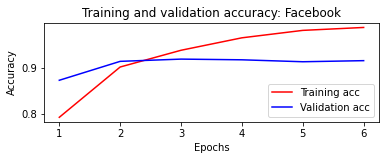

In [ ]:
train_evaluate_model('Facebook')

## Twitter Model

Epoch 1/20
827/827 [==============================] - 796s 944ms/step - loss: 0.4152 - binary_accuracy: 0.8069 - val_loss: 0.2259 - val_binary_accuracy: 0.9093
Epoch 2/20
827/827 [==============================] - 779s 942ms/step - loss: 0.2219 - binary_accuracy: 0.9091 - val_loss: 0.2000 - val_binary_accuracy: 0.9244
Epoch 3/20
827/827 [==============================] - 778s 941ms/step - loss: 0.1583 - binary_accuracy: 0.9391 - val_loss: 0.2097 - val_binary_accuracy: 0.9217
Epoch 4/20
827/827 [==============================] - 779s 942ms/step - loss: 0.0981 - binary_accuracy: 0.9658 - val_loss: 0.3205 - val_binary_accuracy: 0.9211
Epoch 5/20
827/827 [==============================] - 779s 942ms/step - loss: 0.0641 - binary_accuracy: 0.9811 - val_loss: 0.3639 - val_binary_accuracy: 0.9244
Epoch 5: early stopping


              precision    recall  f1-score   support

    positive       0.94      0.95      0.94      2359
    Negative       0.86      0.85      0.86       949

    accuracy                           0.92      3308
   macro avg       0.90      0.90      0.90      3308
weighted avg       0.92      0.92      0.92      3308



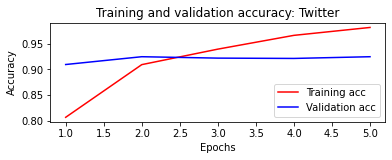

In [ ]:
train_evaluate_model('Twitter')

## Reddit Model

Epoch 1/20
2016/2016 [==============================] - 1946s 959ms/step - loss: 0.2815 - binary_accuracy: 0.8507 - val_loss: 0.1395 - val_binary_accuracy: 0.9434
Epoch 2/20
2016/2016 [==============================] - 1931s 958ms/step - loss: 0.1211 - binary_accuracy: 0.9558 - val_loss: 0.1306 - val_binary_accuracy: 0.9473
Epoch 3/20
2016/2016 [==============================] - 1931s 958ms/step - loss: 0.0877 - binary_accuracy: 0.9701 - val_loss: 0.1469 - val_binary_accuracy: 0.9572
Epoch 4/20
2016/2016 [==============================] - 1932s 958ms/step - loss: 0.0561 - binary_accuracy: 0.9830 - val_loss: 0.2380 - val_binary_accuracy: 0.9334
Epoch 5/20
2016/2016 [==============================] - 1931s 958ms/step - loss: 0.0330 - binary_accuracy: 0.9911 - val_loss: 0.2614 - val_binary_accuracy: 0.9576
Epoch 5: early stopping


              precision    recall  f1-score   support

    positive       0.97      0.96      0.96      3934
    Negative       0.96      0.97      0.96      4127

    accuracy                           0.96      8061
   macro avg       0.96      0.96      0.96      8061
weighted avg       0.96      0.96      0.96      8061



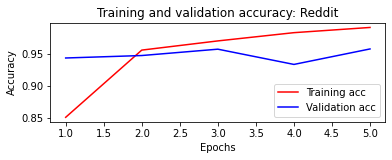

In [ ]:
train_evaluate_model('Reddit')

## Multi-Model

Epoch 1/20
4343/4343 [==============================] - 682s 154ms/step - loss: 0.3805 - binary_accuracy: 0.8193 - val_loss: 0.2240 - val_binary_accuracy: 0.9105
Epoch 2/20
4343/4343 [==============================] - 667s 154ms/step - loss: 0.2110 - binary_accuracy: 0.9152 - val_loss: 0.1938 - val_binary_accuracy: 0.9172
Epoch 3/20
4343/4343 [==============================] - 668s 154ms/step - loss: 0.1515 - binary_accuracy: 0.9427 - val_loss: 0.2056 - val_binary_accuracy: 0.9291
Epoch 4/20
4343/4343 [==============================] - 667s 154ms/step - loss: 0.1026 - binary_accuracy: 0.9643 - val_loss: 0.2274 - val_binary_accuracy: 0.9290
Epoch 5/20
4343/4343 [==============================] - 667s 154ms/step - loss: 0.0698 - binary_accuracy: 0.9790 - val_loss: 0.2800 - val_binary_accuracy: 0.9323
Epoch 5: early stopping


              precision    recall  f1-score   support

    positive       0.94      0.94      0.94      9712
    Negative       0.92      0.92      0.92      7660

    accuracy                           0.93     17372
   macro avg       0.93      0.93      0.93     17372
weighted avg       0.93      0.93      0.93     17372



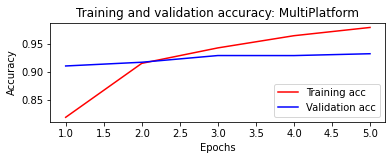

In [ ]:
train_evaluate_model('MultiPlatform')

## Cross Platform Performance

In [ ]:
def cross_performance(model_name, model_path, test_data_path):
  test_data = pd.read_csv(test_data_path)
  model = tf.keras.models.load_model(model_path + model_name)
  predict = model.predict(test_data['comments'].to_numpy())
  pred = []
  for p in predict:
    if p >= 0.5:
      pred.append(1)
    else:
      pred.append(0)
  print('Cross Performance By ' + model_name + ' Model\n\n')
  print(classification_report(test_data['sentiment'].to_list(), pred, target_names=['positive', 'Negative']))
  print('\n\n *************** \n')

In [ ]:
model_names = ['Facebook', 'Twitter', 'Reddit', 'MultiPlatform']
model_path = '/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/models/regular_bert/'
test_data_path = '/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/dataset/test_data.csv'

for model_name in model_names:
  cross_performance(model_name, model_path, test_data_path)

Cross Performance By Facebook Model


              precision    recall  f1-score   support

    positive       0.86      0.50      0.64     10822
    Negative       0.59      0.90      0.71      8481

    accuracy                           0.68     19303
   macro avg       0.72      0.70      0.67     19303
weighted avg       0.74      0.68      0.67     19303



 *************** 

Cross Performance By Twitter Model


              precision    recall  f1-score   support

    positive       0.67      0.87      0.75     10822
    Negative       0.73      0.45      0.55      8481

    accuracy                           0.68     19303
   macro avg       0.70      0.66      0.65     19303
weighted avg       0.69      0.68      0.67     19303



 *************** 

Cross Performance By Reddit Model


              precision    recall  f1-score   support

    positive       0.78      0.91      0.84     10822
    Negative       0.86      0.68      0.76      8481

    accuracy                 

## Additional Test

In [16]:
!pip install numpy==1.23.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 30.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3


In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
additional_test = pd.read_csv('/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/dataset/additional_test.csv')
additional_test.sample(5)

,comments,sentiment
1,working ass seeing people die daily home const...,0
80,stop mandatory vaccination group long clearing...,0
61,vaccination 17th century muslim doctors among ...,0
33,yknow think important now kindergarten ask par...,0
0,men coming hpv vaccine nowadays glad people no...,1


In [16]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/models/regular_bert/MultiPlatform')
predict = model.predict(additional_test['comments'].to_numpy())
pred = []
for p in predict:
  if p >= 0.5:
    pred.append(1)
  else:
    pred.append(0)
print(classification_report(additional_test['sentiment'].to_list(), pred, target_names=['positive', 'Negative']))

              precision    recall  f1-score   support

    positive       0.67      0.46      0.54        61
    Negative       0.38      0.59      0.46        34

    accuracy                           0.51        95
   macro avg       0.52      0.52      0.50        95
weighted avg       0.56      0.51      0.51        95

